In [7]:
!pip install gymnasium[atari]
!pip install gymnasium matplotlib numpy
!pip install ale-py
!pip install gymnasium[accept-rom-license]
!pip install tensorflow
!pip install stable-baselines3[extra]
!pip install opencv-python
!pip install git+https://github.com/openai/baselines
!pip install pandas


!python -m atari_py.import_roms /content/Roms.rar

zsh:1: no matches found: gymnasium[atari]


^C
ERROR: Operation cancelled by user
zsh:1: no matches found: gymnasium[accept-rom-license]
zsh:1: no matches found: stable-baselines3[extra]
  Cloning https://github.com/openai/baselines to /private/var/folders/8j/ybvlz2917dl2hfvs0lmx5m8w0000gp/T/pip-req-build-e1poseb_
  Running command git clone --filter=blob:none --quiet https://github.com/openai/baselines /private/var/folders/8j/ybvlz2917dl2hfvs0lmx5m8w0000gp/T/pip-req-build-e1poseb_


In [1]:
from ale_py import ALEInterface
from ale_py.roms import Breakout
import gymnasium as gym
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam
import numpy as np
from tensorflow.keras import layers
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import numpy as np
import cv2
import torch
import pandas as pd







2023-11-05 12:11:30.433200: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
ale = ALEInterface()
ale.loadROM(Breakout)

In [ ]:
def convert_to_grayscale(frame):
    height, width = frame.shape[:2]
    shape = frame.shape
    grayscale = np.zeros(shape=(height, width))
    for x in range(shape[0]):
      for y in range(shape[1]):
        grayscale[x, y] = np.sum(frame[x][y])/3

    #rescales the frame
    res = cv2.resize(grayscale,(84, 84), interpolation = cv2.INTER_AREA)
    return res


In [ ]:
# import random
# env = gym.make("BreakoutNoFrameskip-v4", render_mode="rgb_array") #, render_mode="human"
# observation, info = env.reset()
# np.set_printoptions(threshold = np.inf)

# next_frame, reward, terminated, truncated, info = env.step(1)
# print('Reward Recieved = ' + str(reward))
# print('Next state is a terminal state: ' + str(terminated))
# print('info[ale.lives] tells us how many lives we have. Lives: ' + str(info['lives']))
# print(env.reward_range)

# for i in range(10000):
#     a = 3 #random.sample([0,1,2,3] , 1)[0]
#     next_frame, reward, terminated, truncated, info = env.step(a)
#     print(next_frame)
#     print("hey")
#     env.render()
#     if truncated == True:
#         env.reset()


In [ ]:
# class QNetwork(nn.Module):
#     def __init__(self, env):
#         super().__init__()
#         self.network = nn.Sequential(
#             nn.Conv2d(4, 32, 8, stride=4),
#             nn.ReLU(),
#             nn.Conv2d(32, 64, 4, stride=2),
#             nn.ReLU(),
#             nn.Conv2d(64, 64, 3, stride=1),
#             nn.ReLU(),
#             nn.Flatten(),
#             nn.Linear(3136, 512),
#             nn.ReLU(),
#             nn.Linear(512, env.single_action_space.n),
#         )
#     def forward(self, x):
#         return self.network(x / 255.0)

In [ ]:
def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope = (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)

In [ ]:


class CustomAtariWrapper(gym.Wrapper):
    def __init__(self, env):
        super(CustomAtariWrapper, self).__init__(env)
        self.observation_space = gym.spaces.Box(0, 255, shape=(84, 84, 1), dtype=np.uint8)


    def reset(self, **kwargs):
        observation = self.env.reset(**kwargs)
        return self.preprocess(observation)

    def step(self, action):
        observation, reward, done, info = self.env.step(action)
        return self.preprocess(observation), reward, done, info

    def preprocess(self, frame):
      height, width = frame.shape[:2]
      shape = frame.shape
      grayscale = np.zeros(shape=(height, width))
      for x in range(shape[0]):
        for y in range(shape[1]):
          grayscale[x, y] = np.sum(frame[x][y])/3

      #rescales the frame
      res = cv2.resize(grayscale,(84, 84), interpolation = cv2.INTER_AREA)
      return res

    # def preprocess(self, observation):
    #     # Convert  grayscale
    #     grayscale_observation = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)

    #     # Resize to 84x84
    #     resized_observation = cv2.resize(grayscale_observation, (84, 84), interpolation=cv2.INTER_AREA)

    #     # Reshape to (84, 84, 1)
    #     reshaped_observation = np.expand_dims(resized_observation, axis=-1)

    #     return reshaped_observation





In [ ]:
"""
Title: Deep Q-Learning for Atari Breakout
Author: [Jacob Chapman](https://twitter.com/jacoblchapman) and [Mathias Lechner](https://twitter.com/MLech20)
Date created: 2020/05/23
Last modified: 2020/06/17
Description: Play Atari Breakout with a Deep Q-Network.
Accelerator: NONE
"""
"""
## Introduction

This script shows an implementation of Deep Q-Learning on the
`BreakoutNoFrameskip-v4` environment.

This example requires the following dependencies: `baselines`, `atari-py`, `rows`.
They can be installed via:

```
git clone https://github.com/openai/baselines.git
cd baselines
pip install -e .
git clone https://github.com/openai/atari-py
wget http://www.atarimania.com/roms/Roms.rar
unrar x Roms.rar .
python -m atari_py.import_roms .
```

### Deep Q-Learning

As an agent takes actions and moves through an environment, it learns to map
the observed state of the environment to an action. An agent will choose an action
in a given state based on a "Q-value", which is a weighted reward based on the
expected highest long-term reward. A Q-Learning Agent learns to perform its
task such that the recommended action maximizes the potential future rewards.
This method is considered an "Off-Policy" method,
meaning its Q values are updated assuming that the best action was chosen, even
if the best action was not chosen.

### Atari Breakout

In this environment, a board moves along the bottom of the screen returning a ball that
will destroy blocks at the top of the screen.
The aim of the game is to remove all blocks and breakout of the
level. The agent must learn to control the board by moving left and right, returning the
ball and removing all the blocks without the ball passing the board.

### Note

The Deepmind paper trained for "a total of 50 million frames (that is, around 38 days of
game experience in total)". However this script will give good results at around 10
million frames which are processed in less than 24 hours on a modern machine.

### References

- [Q-Learning](https://link.springer.com/content/pdf/10.1007/BF00992698.pdf)
- [Deep Q-Learning](https://deepmind.com/research/publications/human-level-control-through-deep-reinforcement-learning)
"""
"""
## Setup
"""

from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import deque

reward_loss = pd.DataFrame(columns=['reward', 'loss'])
# Configuration paramaters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 256  # Size of batch taken from replay buffer
max_steps_per_episode = 10000

env = gym.make("BreakoutNoFrameskip-v4m") #, render_mode="human"

# Warp the frames, grey scale, stake four frame and scale to smaller ratio
env = gym.wrappers.AtariPreprocessing(env)

env.seed(seed)


"""
## Implement the Deep Q-Network

This network learns an approximation of the Q-table, which is a mapping between
the states and actions that an agent will take. For every state we'll have four
actions, that can be taken. The environment provides the state, and the action
is chosen by selecting the larger of the four Q-values predicted in the output layer.

"""

num_actions = 4


def create_q_model():

    # Network defined by the Deepmind paper
    inputs = layers.Input(
        shape=(
            84,
            84,
            4,
        )
    )

    # Convolutions on the frames on the screen
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)


# The first model makes the predictions for Q-values which are used to
# make a action.
model = create_q_model()
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model()


"""
## Train
"""
# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 50000
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 100000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10000
# Using huber loss for stability
loss_function = keras.losses.Huber()

loss_tracker = []
save_count = 0
#if loss less than minimun of this list then save model
loss = None
while True:  # Run until solved
    state = np.array(env.reset())

    episode_reward = 0
    frame_stack = deque(maxlen=4)
    frame_stack_state_sample = deque(maxlen=4)
    count = 0




    for timestep in range(1, max_steps_per_episode):

        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1


        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done, trunk, _ = env.step(action)
        episode_reward += reward

        frame_stack.append(state_next)


        count+=1
        if(count == 4):
          count = 0
          state_next = np.array(state_next)
          #print(state_next.shape)


          # Save actions and states in replay buffer
          action_history.append(action)
          #state_history.append(state)

          frame_stack.append(state_next)
          stacked_state = np.stack(frame_stack, axis=-1)

          frame_stack_state_sample.append(state)
          state_his_stack = np.stack(frame_stack, axis=-1)


          state_next_history.append(stacked_state)
          state_history.append(state_his_stack)

          #print(stacked_state.shape)


          done_history.append(done)
          rewards_history.append(reward)
          state = state_next
          #print(len(state_next_history))




        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
            #state_next_history.append(stacked_state)
            #frame_stack.clear()

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )



            # Build the updated Q-values for the sampled future states
            # Use the target model for stability

            # state_next_sample = np.reshape(state_next_sample, (batch_size, 84, 84, 4))




            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                state_sample = tf.convert_to_tensor(state_sample, dtype=tf.float32)
                #print(state_sample.shape)



                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)
                loss_tracker.append(loss)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details


            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]



        if done:
            break

    # Update running reward to check condition for solving
    if(loss != None):
      print("Episode Count ", episode_count, "EPSIODE_rEWARD:", episode_reward, "Loss:", loss.numpy() )
      save_count +=1
      s = pd.Series([episode_reward,loss.numpy()],index=['reward', 'loss'], name=save_count)
      reward_loss = pd.concat([reward_loss, s.to_frame().T])
      reward_loss.to_csv('/content/gdrive/My Drive/dataframe_rl.csv')
      print(reward_loss)
    if(episode_count % 10 == 0  ):

      model.save('/content/gdrive/My Drive/my_model_episode.hdf5')
    if len(loss_tracker) != 0 and loss.numpy() < np.min(loss_tracker):
        model.save('/content/gdrive/My Drive/my_model.hdf5')

    episode_reward_history.append(episode_reward)

    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]

    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if running_reward > 40:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break


#how tf do

In [ ]:
#keeps track of the agents memory
def Agent_memory():
    def __init__(self):
        self.action_memory = []
        self.frame_memory = []
        self.reward_memory = []
        self.next_state_memory = []
#function to keep adding to the memory
    def add_memory(self, next_frame, next_frames_reward, next_action):
        self.frame_memory.append(next_frame)
        self.action_memory.append(next_action)
        self.reward_memory.append(next_frames_reward)
        #self.done_flags.append(next_frame_terminal)

# s to s-, need ot know all possible values of s dash and the probablity matrix,
# for each state and all possibnle acto what is the prbablity of going to next staticmethod
#     function promixater, you tell it what state, what action u are taking and tell u what the value of ur next state is
# that has to be train, the function promixer is the NN, action value function. try to find a value action function.
#given the state, how can we find these variables, the more state space more complex, x, y, vx
#define state space, define actions, we have to define gamma,

In [ ]:
learning_rate = 0.5
epsilon = 0.99
gamma = 0.99
episodes = 100
max_timesteps = 10

In [ ]:
class Agent():
    def __init__(self, possible_actions, starting_mem_len, max_mem_len, starting_epsilon, learn_rate, starting_lives = 5, debug = False) -> None:
       pass
    '''gets the next set of actions from what the agent learns'''
    def get_action(self):
        pass
    def learn(self):
        pass
    def step(self, env, action):
        env.step(action)
        pass


In [2]:
import random
env = gym.make("BreakoutNoFrameskip-v4", render_mode="human") #, render_mode="human"
observation, info = env.reset()

next_frame, reward, terminated, truncated, info = env.step(1)

for i in range(1000000):
    a = env.action_space.sample()
    next_frame, reward, terminated, truncated, info = env.step(a)
    
    env.render()
    if(terminated):
        env.reset()
env.close()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/Users/Ed/opt/anaconda3/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


: 

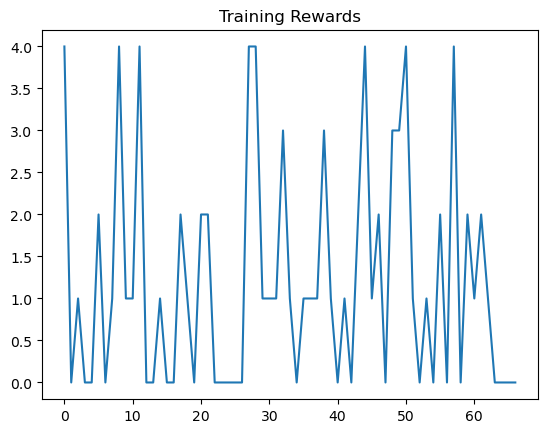

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

s = pd.read_csv('./dataframe_rl.csv')
plt.title('Training Rewards')
plt.plot(s['reward'])
plt.show()


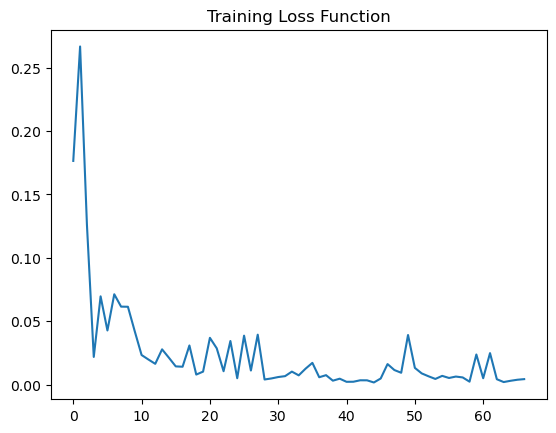

In [7]:
plt.title('Training Loss Function')
plt.plot(s['loss'])
plt.show()

In [ ]:
def q_learning(self, current_position, enochs, epsilon, gamma):
  history = Agent_memory()

  pass